# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
# !pip -q install ./python # uncomment to install additional local packages for the 1st time running

In [1]:
import numpy as np
import torch
from collections import deque
from time import time
import matplotlib.pyplot as plt

In [2]:
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name='Reacher_v2.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:\n', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like:
 [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [10]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

count = 1
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    
    with np.printoptions(precision=3, suppress=True):
        print('\rStep {:3d}\tAction {}\tReward {:.2f}'.format(count,actions[0], rewards[0]), end="")
    count += 1
    
    if np.any(dones):                                  # exit loop if episode finished
        break
print('\nTotal score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Step 1001	Action [-0.904  0.584 -1.    -1.   ]	Reward 0.00
Total score (averaged over agents) this episode: 0.11749999737367034


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

#### 4.1 Instantiate the Environment and Agent

In [7]:
from ddpg_agent import Agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)

#### 4.2 Train the Agent with DDPG

In [8]:
def ddpg(n_episodes=1000, max_t=2000):    
    scores_deque = deque(maxlen=100)
    scores_list  = []
    
    for i_episode in range(1, n_episodes+1):  
        t1 = time()
        
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        states = env_info.vector_observations
        scores = np.zeros(num_agents) 
        
        for t in range(max_t):  
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations      # get the next state
            rewards = env_info.rewards                      # get the reward
            dones = env_info.local_done                     # see if episode has finished
            
            agent.step(states, actions, rewards, next_states, dones, t)
            
            states = next_states
            scores += rewards
            if np.any(dones):
                break 
        
        scores_deque.append(np.mean(scores))
        scores_list.append(np.mean(scores))
        
        t2 = time()
        
        print('\rEpisode {}\tCurrent Score {:.2f}\tAverage Score: {:.2f}\tTime: {} seconds'\
              .format(i_episode, scores_deque[-1], np.mean(scores_deque),int(t2-t1)), end='')
        
        if i_episode % 10 == 0: print()
                   
        if np.mean(scores_deque) > 30:
            print('\nProbelm solved!')
            torch.save(agent.actor_local.state_dict(),  'checkpoint_actor_solved.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_solved.pth')
            break
            
    torch.save(agent.actor_local.state_dict(),  'checkpoint_actor.pth')
    torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            
    return scores_list

In [9]:
start_time = time()

scores = ddpg()

end_time   = time()
tot_time   = end_time - start_time
print("\nTotal training time: {:2} minutes {:2} seconds".format(int(tot_time/60), int(tot_time%60)))

Episode 10	Current Score 2.33	Average Score: 1.15	Time: 20 seconds
Episode 20	Current Score 12.94	Average Score: 3.50	Time: 29 seconds
Episode 30	Current Score 36.48	Average Score: 11.56	Time: 23 seconds
Episode 40	Current Score 38.54	Average Score: 18.04	Time: 22 seconds
Episode 50	Current Score 33.52	Average Score: 21.55	Time: 23 seconds
Episode 60	Current Score 36.92	Average Score: 24.04	Time: 24 seconds
Episode 70	Current Score 36.49	Average Score: 25.78	Time: 27 seconds
Episode 80	Current Score 36.65	Average Score: 27.19	Time: 21 seconds
Episode 90	Current Score 37.29	Average Score: 28.26	Time: 23 seconds
Episode 100	Current Score 37.73	Average Score: 29.15	Time: 22 seconds
Episode 103	Current Score 37.73	Average Score: 30.23	Time: 22 seconds
Probelm solved!

Total training time: 40 minutes 53 seconds


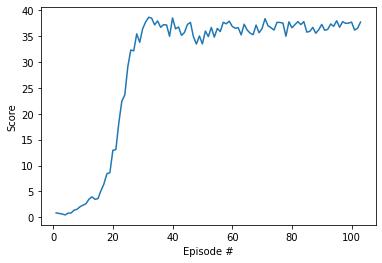

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### 4.3 Watch a Smart Agent

In [6]:
from ddpg_agent import Agent
agent = Agent(state_size=state_size, action_size=action_size, random_seed=0)

In [11]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor_solved.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic_solved.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)

count = 1
while True:
    actions = agent.act(states, add_noise=False)                        
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    scores += rewards
    states = next_states
    
    with np.printoptions(precision=3, suppress=True):
        print('\rStep {:3d}\tAction {}\tReward {:.2f}'.format(count,actions[0], rewards[0]), end="")
    count += 1
    
    if np.any(dones):
        break       
print('\nTotal score (averaged over agents) this episode: {:.1f}'.format(np.mean(scores)))

Step 1001	Action [ 0.538  0.208 -0.524  0.807]	Reward 0.04
Total score (averaged over agents) this episode: 39.4


When finished, you can close the environment.

In [12]:
env.close()